# Understanding Crowding in TESS data

Welcome everyone to our *TESS* Lightkurve tutorial!

## Authors

[Rebekah Hounsell](https://heasarc.gsfc.nasa.gov/docs/tess/helpdesk.html) - Support scientist for *TESS* in the NASA GSFC GI Office. 


## Learning goals

In this tutorial, we will teach the user about crowding in the *TESS* data products and how to correct for it. 

The tutorial assumes a basic knowledge of python and astronomy, and will walk the user through several of the concepts outlined below:

1. Downloading and comparing LightCurve Object data
2. Examining a TargetPixel File (TPF) for crowding
3. Creating a light curve from a TPF
4. Removing the effects of scattered light and noise
5. Removing the effects of crowding

This tutorial is designed for users that have previous experience with *Lightkurve*.

## Imports

This tutorial requires the use of specific packages:
- [**Lightkurve**](https://docs.lightkurve.org/index.html) to work with *TESS* data (v2.0.1)
- [**Matplotlib**](https://matplotlib.org/) for plotting.
- [**Numpy**](https://numpy.org) for manipulating the data.

## First time users

If you are not that experienced with *Python*, or cannot download *Lightkurve*, you can run this notebook as a [Colab notebook](https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index). Colaboratory allows users to write and execute *Python* in your browser with zero configuration required. 

All you need is a Google account and to copy and paste in the following command at the top of your colab notebook:

`!pip install git+https://github.com/lightkurve/lightkurve.git --quiet`

This downloads the *Lightkurve* package.

In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from lightkurve.correctors import RegressionCorrector, DesignMatrix
from lightkurve.correctors import PLDCorrector
import warnings

## Introduction into crowding 

*TESS* photometry, while high-cadence and of high quality, does suffer from crowding issues. 
A single *TESS* pixel corresponds to 21 arcseconds (~0.35 arc min) on sky and the *TESS* Pixel Response Function (PRF) is very large compared to the pixel. A target of interest may therefore be contaminated by any number of neighboring objects, and it is important that the light from these other objects be accounted for and removed. 

For exoplanets, if this excess flux is not removed, it can cause a decrease in the apparent planet transit depth and lead to a systematic underestimation of the planet radii.

[LightCurve Objects](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html) have been corrected for this crowding via the data processing pipeline developed by the Science Processing Operations Center (SPOC). A description of this correction and its application is provided in Section 2.3.11 of [this paper](https://iopscience.iop.org/article/10.1086/667698/pdf). The correction however is applied only to the PDCSAP flux and not the SAP flux. 

The crowding correction applied focuses on two parameters:
 - The crowding metric: This reflects what fraction of the flux in the aperture is due to the target itself, not the nearby light sources. 
 - The flux fraction: Similar to excess flux leaking into the aperture, a fraction of the PRF of the target may not be captured in it. To account for this missing fraction, the flux fraction is computed.
 
If PDCSAP flux is not available, the user may apply the corrections outlined below to remove not only the instrumental noise, but any additional crowding effect.

## 1. Downloading and comparing LightCurve Object data

In this tutorial we will be examining at the binary star system [WR21a](https://en.wikipedia.org/wiki/WR_21a). Let's first see if there are any LightCurve objects avalible for download. 

In [2]:
search_lk = lk.search_lightcurve("WR21a")
search_lk

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 09,2019,QLP,1800,464570167,0.0
1,TESS Sector 10,2019,QLP,1800,464570167,0.0
2,TESS Sector 36,2021,SPOC,120,464570167,0.0
3,TESS Sector 37,2021,SPOC,120,464570167,0.0


OK, great! There are data for multiple sectors. For this tutorial, we will examining data from Sector 36 which is provided by the SPOC. We can download this via the following functions,

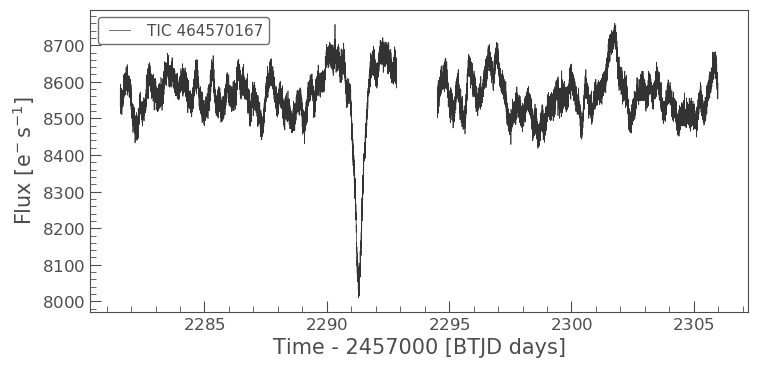

In [3]:
lc36 = search_lk[2].download()
lc36.plot()

This very clearly shows the transit of the system. The flux displayed is the PDCSAP flux which has been fully corrected. Let's see what the SAP flux looks like in comparison. We can do this by specifying the column in the plot function.

(2290, 2293)

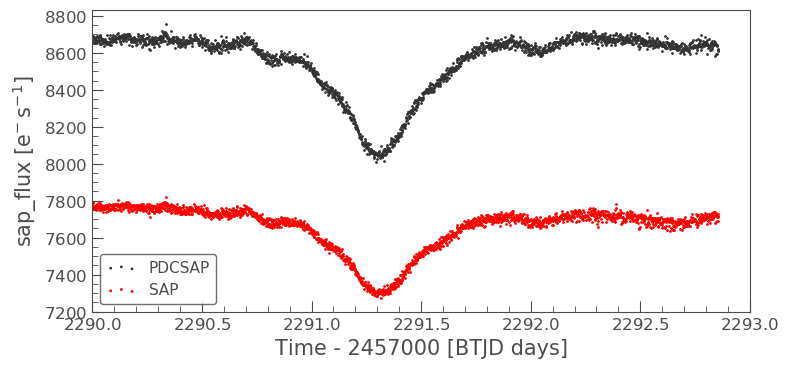

In [4]:
ax = lc36.scatter(normalize=False, label='PDCSAP')
lc36.scatter(ax=ax, column='sap_flux', normalize=False, color='red', label='SAP')
plt.xlim(xmin=2290, xmax=2293)


The above plot clearly indicates the significant difference in amplitude between the PDCSAP and SAP flux. The plot illustrates how much of a difference the flux fraction and crowding metric can change the absolute magnitudes of the light curves.

Now we plot the normalized PDCSAP and SAP flux to show that the transit depth has changed.

(2290, 2293)

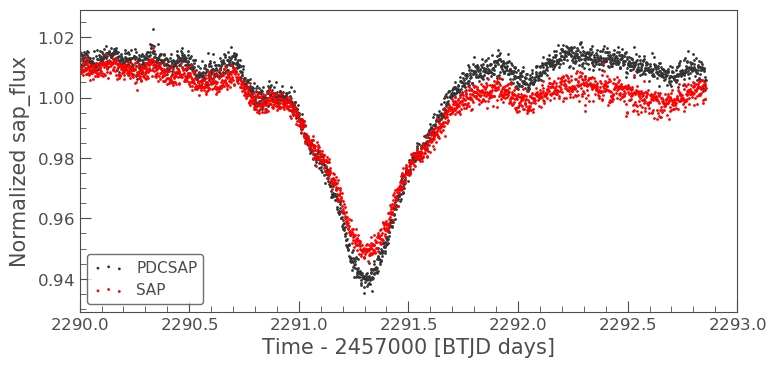

In [5]:
ax = lc36.scatter(normalize=True, label='PDCSAP')
lc36.scatter(ax=ax, column='sap_flux', normalize=True, color='red', label='SAP')
plt.xlim(xmin=2290, xmax=2293)

The transit depth of the SAP flux is not the same as the PDCSAP. This difference is a good indication that the data suffers from crowding.

## 2. Examining a Target Pixel File for crowding

To fully appreciate how crowded our object is, we can examine its surroundings via downloading and plotting the associated TargetPixel File (TPF).

In [6]:
tpf = lk.search_targetpixelfile('WR21a', sector=36).download(quality_bitmask='hard')

Note for this tutorial we are specifing the `quality_bitmask` to be 'hard'. This is to ensure that only good quality data is downloaded. We can now plot our TPF and display the aperture mask that has been defined by the SPOC for our object of interest. 

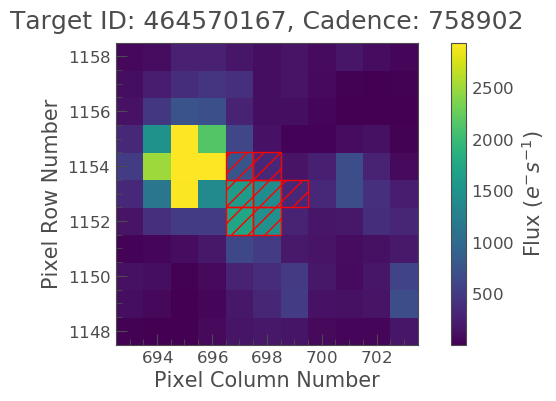

In [7]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

The above plot indicates that we are focusing on the right object, but that it is indeed crowded by a much brighter star and as such, we need to remove the contaminating flux.


## 3. Creating a light curve from a TPF 
To do this, we must first create the light curve of the object using the default mask, as shown below.

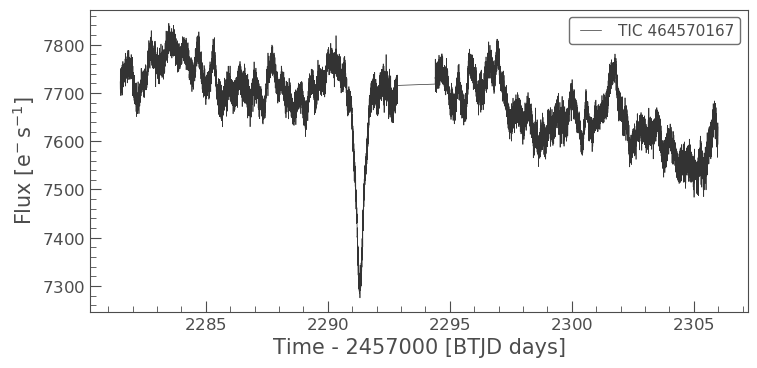

In [8]:
tpf_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
tpf_lc.plot()

A quick glance at this light curve indicates that there are also long term trends/noise that need to be removed before we can correct for crowding.

## 4. Removing the effects of scattered light and noise

As indicated above, the SAP light curve is effected by scattered light and noise. We must remove this before correcting for crowding. To do this, we can used one of *Lighkurves* built in corrector functions, in this case [Pixel Level Decorrelation (PLD)](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-k2-pldcorrector.html).

The inputs required are the TPF, the aperture, and the number of principal componants.

/Users/rhounsel/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/utils/decorators.py:535: LightkurveDeprecationWarning: "aperture_mask" was deprecated in version 2.0 and will be removed in a future version. 
  return function(*args, **kwargs)


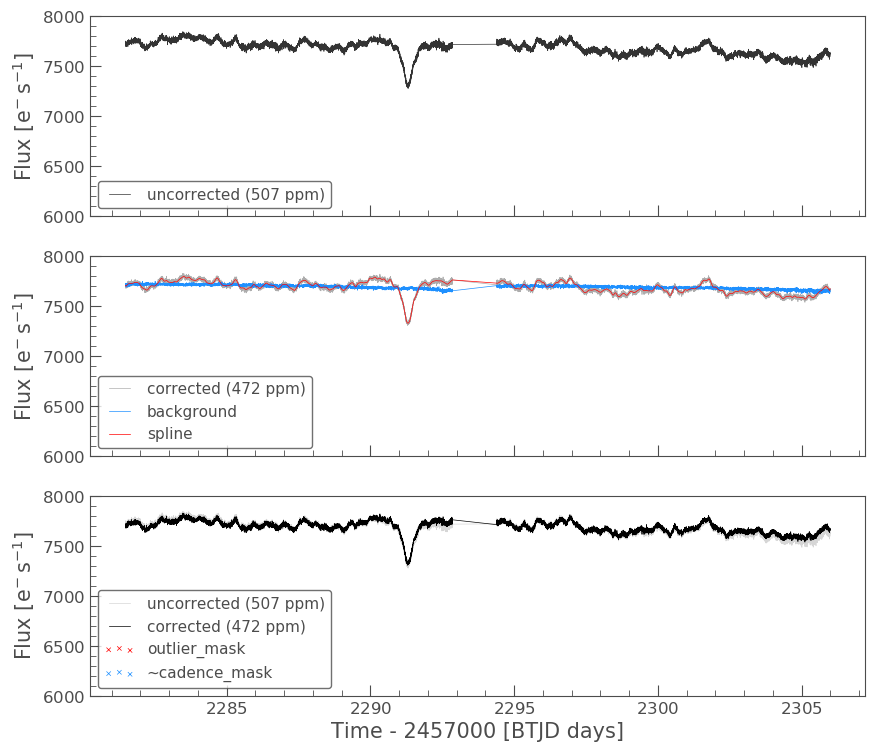

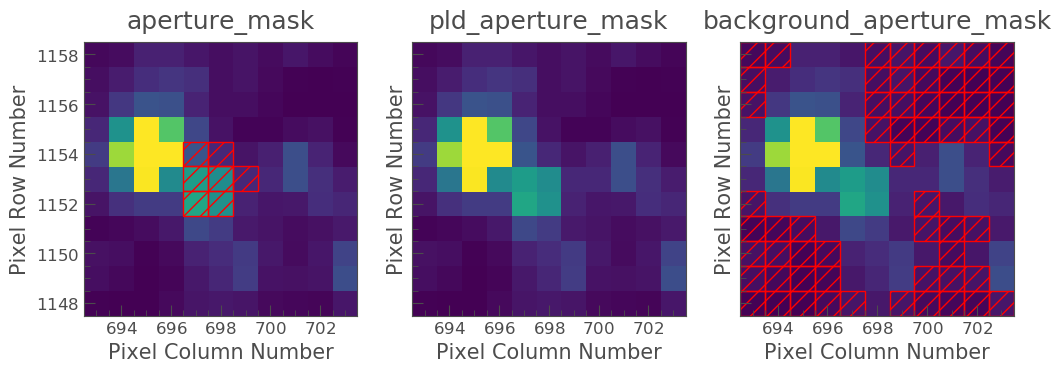

In [9]:
pld = PLDCorrector(tpf, aperture_mask=tpf.pipeline_mask)
pld.correct(pca_components=5)
pltAxis = pld.diagnose()
pltAxis[0].set_ylim(ymin=6000, ymax=8000)
pltAxis[1].set_ylim(ymin=6000, ymax=8000)
pltAxis[2].set_ylim(ymin=6000, ymax=8000)


pld.diagnose_masks();
pld_lc = pld.correct(pca_components=5, aperture_mask=tpf.pipeline_mask)

Let's compare this corrected light curve with our previous light curves.

(2290, 2293)

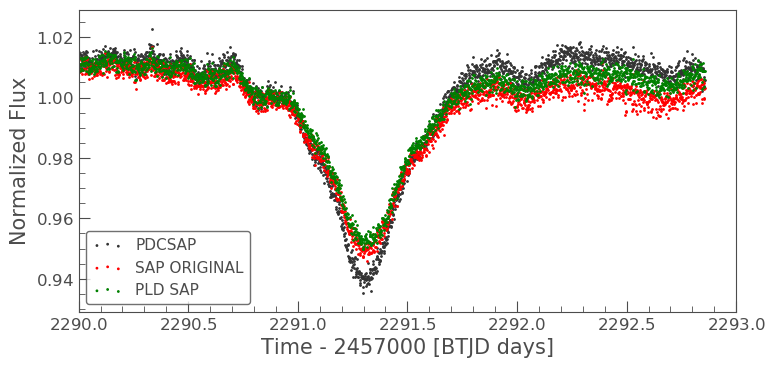

In [10]:
ax = lc36.scatter(normalize=True, label='PDCSAP')
tpf_lc.scatter(ax=ax, normalize=True, color='red', label='SAP ORIGINAL')
pld_lc.scatter(ax=ax, normalize=True, color='green', label='PLD SAP')
plt.xlim(xmin=2290, xmax=2293)

The depth of the PLD SAP light curve still does not match that of the PDCSAP, but there is some improvement in the light curve overall. Let's now apply the crowding correction to the pld_lc.

## 5. Removing the effects of crowding

To do this, we must first pull out the two parameters we need to calculate the correction - CROWDSAP and FLFRCSAP

In [11]:
CROWDSAP = tpf.hdu[1].header['CROWDSAP']

In [12]:
CROWDSAP

0.78926158

In [13]:
FLFRCSAP = tpf.hdu[1].header['FLFRCSAP']

In [14]:
FLFRCSAP

0.7079128

From the above values, we see that the aperture contains only 71% of the object's flux, and an extra 21% of the flux in the aperture is due to other objects.

To correct for the crowding and missing flux, we must first calculate the median flux of our time series. Note that we want only data that is of a high quality, which is why we originally set our `quality_mask` as hard. 

In [15]:
median_flux = np.median(pld_lc.flux.value)

The excess flux in the aperture is then calculated as (1-CROWDSAP) times the median flux

In [16]:
excess_flux = (1-CROWDSAP)*median_flux

This excess flux must then be subtracted from the time series data

In [17]:
flux_removed = pld_lc.flux.value  - excess_flux

This residual flux, however, does not account for the flux of our object outside of the aperture, as such there is one more correction to apply - FLFRCSA.

In [18]:
flux_corr = flux_removed/FLFRCSAP

The uncertainties on this flux are also now altered to be

In [19]:
flux_err_corr = pld_lc.flux_err.value/FLFRCSAP

We can now convert this into a LightCurve Object again via the following

In [20]:
lc_corr = lk.LightCurve(time=tpf.time.value, flux=flux_corr, flux_err=flux_err_corr)

Let's plot and compare to our previous light curves. 

(2290, 2293)

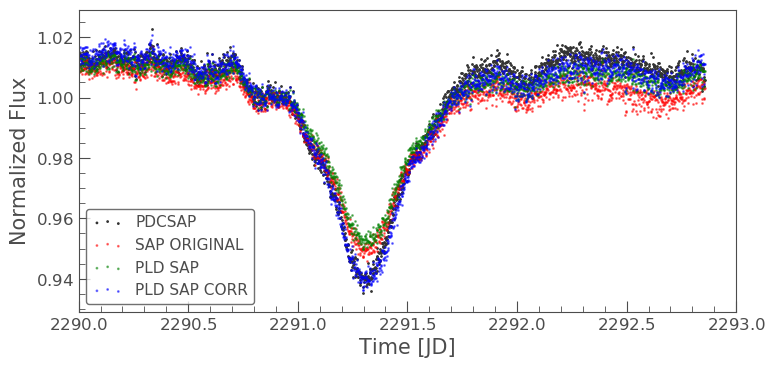

In [21]:
ax = lc36.scatter(normalize=True, label='PDCSAP')
tpf_lc.scatter(ax=ax, normalize=True, color='red', label='SAP ORIGINAL', alpha=0.5)
pld_lc.scatter(ax=ax, normalize=True, color='green', label='PLD SAP', alpha=0.5)
lc_corr.scatter(ax=ax, normalize=True, color='blue', label='PLD SAP CORR', alpha=0.5)
plt.xlim(xmin=2290, xmax=2293)

In [22]:
np.nanmedian(lc_corr.flux.value)

8574.747152437736

The corrected light curve is now significantly closer to that of the PLDSAP light curve. There are still some minor descrpancies,  but these are are realated primarily to the removal of noise. Adjustments in the noise removal procedure applied to the SAP light curve can further improve this reduction.

Let's try another method - the CBV corrector.

## CBVCorrector

In [23]:
from lightkurve.correctors import CBVCorrector
cbvCorrector = CBVCorrector(tpf_lc)
cbvCorrector.cbvs

[TESS CBVs, Sector.Camera.CCD : 36.3.1, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 36.3.1, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 36.3.1, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 36.3.1, CBVType.Band: MultiScale.3, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 36.3.1, CBVType : Spike, nCBVS : 6]

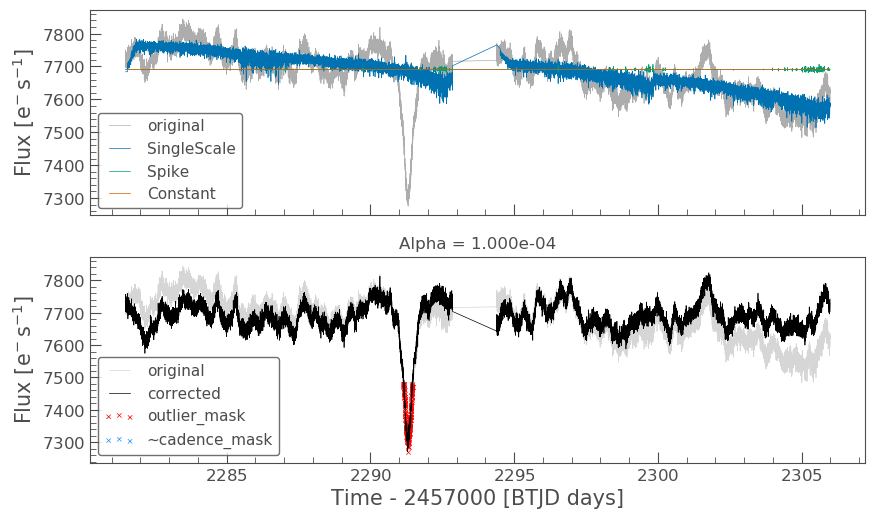

In [24]:
# Select which CBVs to use in the correction
cbv_type = ['SingleScale', 'Spike']
cbv_indices = [np.arange(1,9), 'ALL']
# Perform the correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)
cbvCorrector.diagnose();

Let's check to see if we have over or underfit the data.

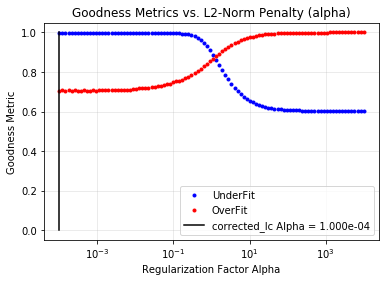

In [25]:
with warnings.catch_warnings():
    # ignore "RuntimeWarning"
    warnings.simplefilter("ignore", RuntimeWarning)
    cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

We might be slightly overfitting, so let's adjust our alpha.

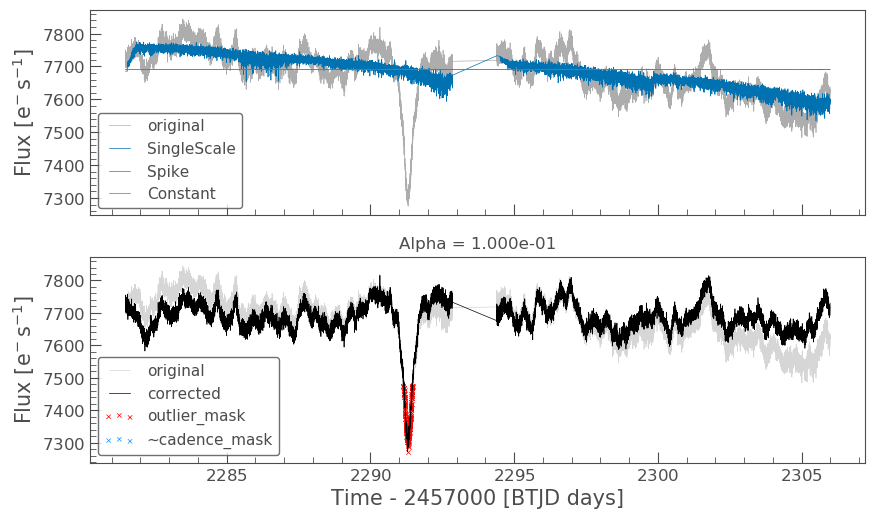

In [26]:
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-1)
cbvCorrector.diagnose();

Now we can apply the crowding corrections. 

In [27]:
# Perform the FF and CM corrections
median_flux = np.median(cbvCorrector.corrected_lc.flux.value)
excess_flux = (1-CROWDSAP)*median_flux
flux_removed = cbvCorrector.corrected_lc.flux.value  - excess_flux
flux_corr = flux_removed/FLFRCSAP
flux_err_corr = cbvCorrector.corrected_lc.flux_err.value/FLFRCSAP
lc_cbv_corr = lk.LightCurve(time=tpf.time.value, flux=flux_corr, flux_err=flux_err_corr)

We can now compare to the PDCSAP and SAP light curves. 

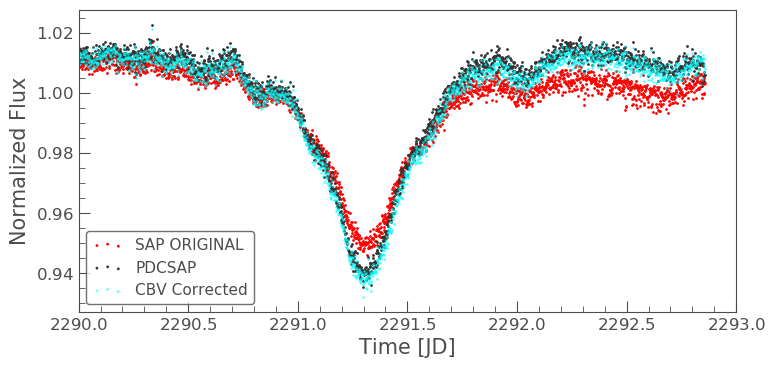

In [28]:
ax = tpf_lc.scatter(normalize=True, color='red', label='SAP ORIGINAL')
lc36.scatter(ax=ax, normalize=True, label='PDCSAP')
lc_cbv_corr.scatter(ax=ax, normalize=True, color='cyan', label='CBV Corrected', alpha=0.5)
plt.xlim(xmin=2290, xmax=2293);

Finally, we can compare our PLD and CBV corrected light curves.

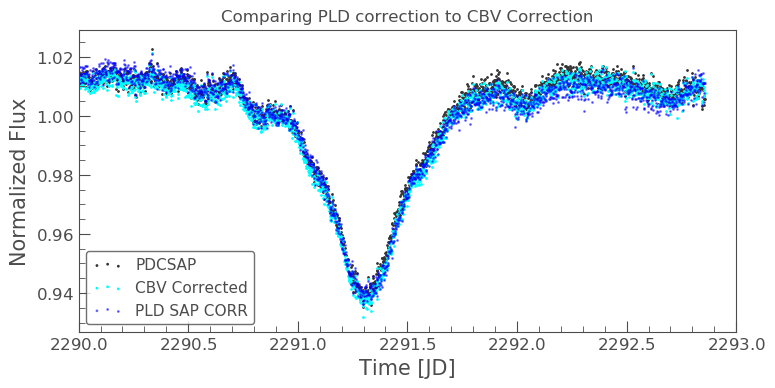

In [29]:
ax = lc36.scatter(normalize=True, label='PDCSAP')
lc_cbv_corr.scatter(ax=ax, normalize=True, color='cyan', label='CBV Corrected')
lc_corr.scatter(ax=ax, normalize=True, color='blue', label='PLD SAP CORR', alpha = 0.5)
plt.title('Comparing PLD correction to CBV Correction')
plt.xlim(xmin=2290, xmax=2293);

The CBV light curve might be a better match to the PDCSAP. 